In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/AnomalyDetection/src')

from preprocessing import load_dataset, preprocess, preprocess2
from models import build_isolation_forest, run_iforest
from utils import plot_scores, plot_dual_anomalies


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/AnomalyDetection/src')

import preprocessing
from importlib import reload
reload(preprocessing)


import inspect
print(inspect.getsource(preprocessing))


import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_dataset(path):
    return pd.read_csv(path)

def preprocess(df):
    df = df.copy()

    # sortam dupa timestamp
    if "timestamp" in df.columns:
        df = df.sort_values("timestamp")

    # completam valorile lipsa
    df = df.fillna(method="ffill")
    df = df.fillna(method="bfill")

    # lista de features din dataset
    features = [
        "RSSI",
        "SNRCurrent_URLLC",
        "RSRQCurrent_URLLC",
        "RSRPCurrent_URLLC",
        "BytesSent_URLLC",
        "BytesReceived_URLLC",
        "BytesSent_eMBB",
        "BytesReceived_eMBB",
        "URLLC_BytesSent",
        "URLLC_BytesReceived",
        "eMBB_BytesSent",
        "eMBB_BytesReceived",
        "URLLC_Sent_thrp_Mbps",
        "URLLC_Received_thrp_Mbps",
        "eMBB_Sent_thrp_Mbps",
        "eMBB_Received_thrp_Mbps"
    ]

    # ne asiguram ca toate exista
    features = [f for f in features if f in df.columns]

    print("Folos

In [4]:
path = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal_processed.csv"
df = load_dataset(path)
df.shape

df.columns.tolist()


['timestamp',
 'imsi',
 'RSSI',
 'SNRCurrent_URLLC',
 'RSRQCurrent_URLLC',
 'RSRPCurrent_URLLC',
 'APN_eMBB',
 'APN_URLLC',
 'BytesSent_URLLC',
 'BytesReceived_URLLC',
 'BytesSent_eMBB',
 'BytesReceived_eMBB',
 'URLLC_BytesSent',
 'URLLC_BytesReceived',
 'eMBB_BytesSent',
 'eMBB_BytesReceived',
 'URLLC_Sent_thrp_Mbps',
 'URLLC_Received_thrp_Mbps',
 'eMBB_Sent_thrp_Mbps',
 'eMBB_Received_thrp_Mbps']

In [5]:
X, scaler = preprocess(df)
X.shape


Folosesc features: ['RSSI', 'SNRCurrent_URLLC', 'RSRQCurrent_URLLC', 'RSRPCurrent_URLLC', 'BytesSent_URLLC', 'BytesReceived_URLLC', 'BytesSent_eMBB', 'BytesReceived_eMBB', 'URLLC_BytesSent', 'URLLC_BytesReceived', 'eMBB_BytesSent', 'eMBB_BytesReceived', 'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps', 'eMBB_Sent_thrp_Mbps', 'eMBB_Received_thrp_Mbps']


/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")
/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(4193, 16)

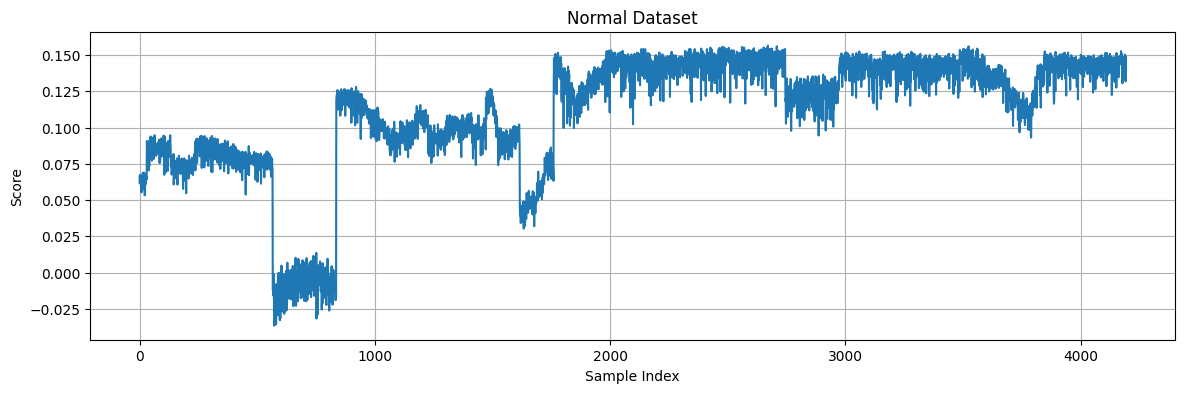

In [6]:
model = build_isolation_forest()
scores, labels = run_iforest(model, X)

plot_scores(scores, "Normal Dataset")


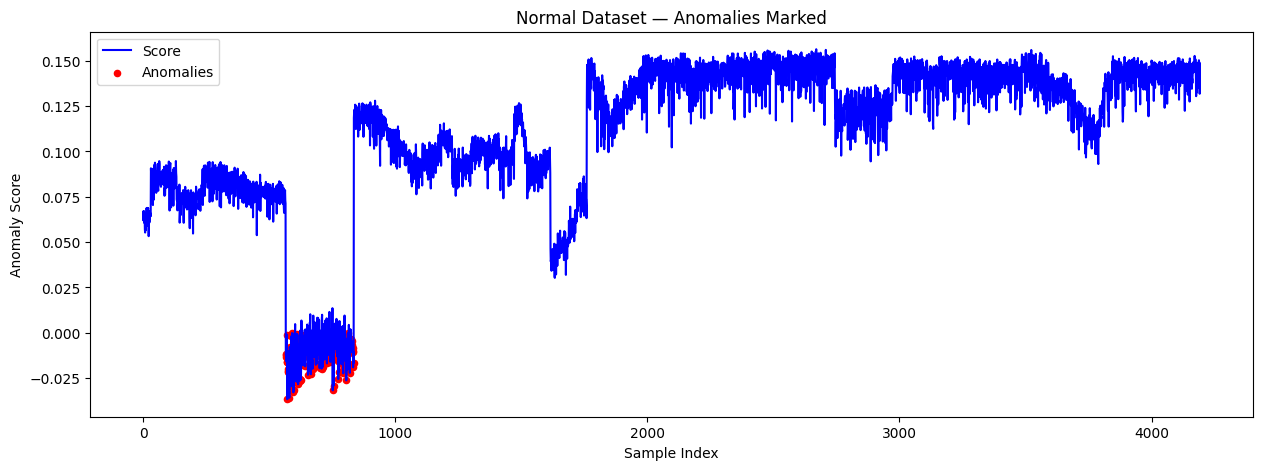

Number of anomalies detected: 210


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_anomalies(scores, labels, title="Anomaly Detection"):
    anomalies = np.where(labels == -1)[0]

    plt.figure(figsize=(15,5))
    plt.plot(scores, label="Score", color="blue")
    plt.scatter(anomalies, scores[anomalies], color="red", label="Anomalies", s=20)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Anomaly Score")
    plt.legend()
    plt.show()

    print(f"Number of anomalies detected: {len(anomalies)}")
    return anomalies

anomalies = plot_anomalies(scores, labels, "Normal Dataset — Anomalies Marked")


In [8]:
import numpy as np
from sklearn.ensemble import IsolationForest

def compute_unsupervised_importance(model, X, n_repeats=5):
    # scor original
    original_scores = model.decision_function(X)

    n_features = X.shape[1]
    importances = np.zeros(n_features)

    for feature_idx in range(n_features):
        diffs = []

        for _ in range(n_repeats):
            X_permuted = X.copy()
            # permutam doar feature-ul curent
            np.random.shuffle(X_permuted[:, feature_idx])

            # scoruri dupa permutare
            perm_scores = model.decision_function(X_permuted)

            # cat de mult se schimba scorurile
            diff = np.mean(np.abs(original_scores - perm_scores))
            diffs.append(diff)

        importances[feature_idx] = np.mean(diffs)

    # normalizare
    importances = importances / importances.sum()
    return importances

importances = compute_unsupervised_importance(model, X)

feature_names = [
    'RSSI', 'SNRCurrent_URLLC', 'RSRQCurrent_URLLC', 'RSRPCurrent_URLLC',
    'BytesSent_URLLC', 'BytesReceived_URLLC', 'BytesSent_eMBB', 'BytesReceived_eMBB',
    'URLLC_BytesSent', 'URLLC_BytesReceived', 'eMBB_BytesSent', 'eMBB_BytesReceived',
    'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps',
    'eMBB_Sent_thrp_Mbps', 'eMBB_Received_thrp_Mbps'
]

for name, imp in zip(feature_names, importances):
    print(f"{name:30s}: {imp:.6f}")


RSSI                          : 0.126295
SNRCurrent_URLLC              : 0.126393
RSRQCurrent_URLLC             : 0.000000
RSRPCurrent_URLLC             : 0.138721
BytesSent_URLLC               : 0.115799
BytesReceived_URLLC           : 0.117650
BytesSent_eMBB                : 0.000000
BytesReceived_eMBB            : 0.000000
URLLC_BytesSent               : 0.098109
URLLC_BytesReceived           : 0.095871
eMBB_BytesSent                : 0.000000
eMBB_BytesReceived            : 0.000000
URLLC_Sent_thrp_Mbps          : 0.079939
URLLC_Received_thrp_Mbps      : 0.101224
eMBB_Sent_thrp_Mbps           : 0.000000
eMBB_Received_thrp_Mbps       : 0.000000


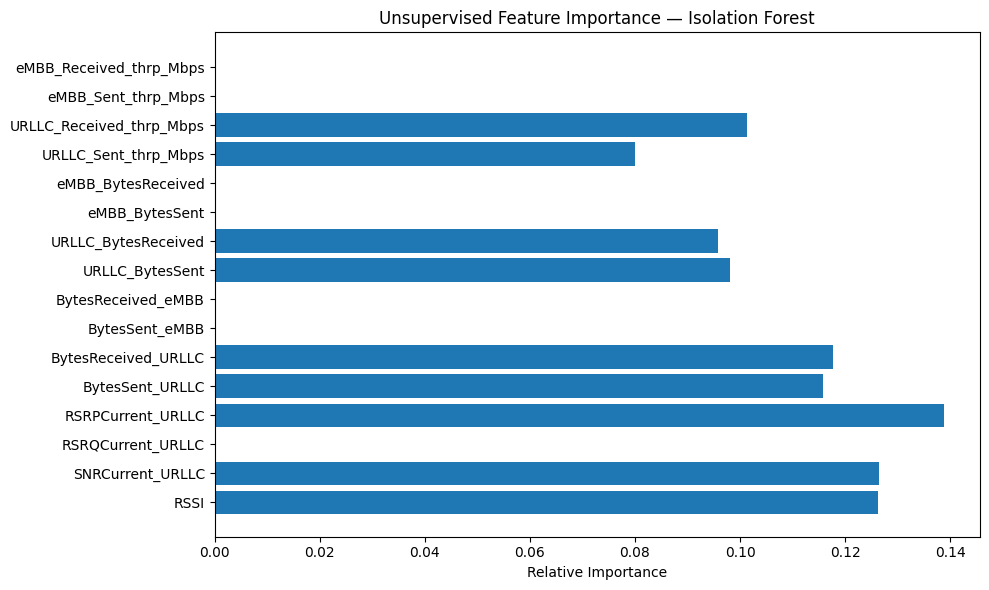

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.title("Unsupervised Feature Importance — Isolation Forest")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


In [10]:
contam_grid = [0.001, 0.002, 0.005, 0.01, 0.02]

results = []
for c in contam_grid:
    model = IsolationForest(contamination=c, random_state=42)
    model.fit(X)
    labels = model.predict(X)
    anomaly_rate = np.mean(labels == -1)
    results.append((c, anomaly_rate))

results


[(0.001, np.float64(0.0011924636298592892)),
 (0.002, np.float64(0.002146434533746721)),
 (0.005, np.float64(0.005008347245409015)),
 (0.01, np.float64(0.01001669449081803)),
 (0.02, np.float64(0.02003338898163606))]

/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")
/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Folosesc features: ['RSSI', 'SNRCurrent_URLLC', 'RSRQCurrent_URLLC', 'RSRPCurrent_URLLC', 'BytesSent_URLLC', 'BytesReceived_URLLC', 'BytesSent_eMBB', 'BytesReceived_eMBB', 'URLLC_BytesSent', 'URLLC_BytesReceived', 'eMBB_BytesSent', 'eMBB_BytesReceived', 'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps', 'eMBB_Sent_thrp_Mbps', 'eMBB_Received_thrp_Mbps']
Anomalii detectate pe normal: 5


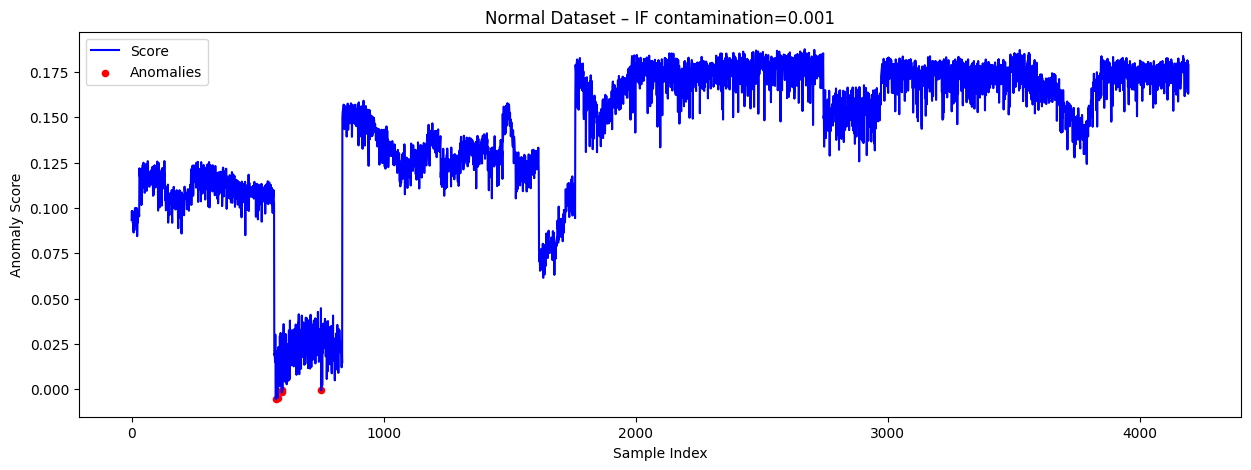

Number of anomalies detected: 5


array([572, 580, 596, 598, 752])

In [11]:
path_normal = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal_processed.csv"
df_normal = load_dataset(path_normal)
X_normal, scaler_normal = preprocess(df_normal)

from sklearn.ensemble import IsolationForest

# Antrenam modelul pe datasetul NORMAL
model = IsolationForest(contamination=0.001, random_state=42)
model.fit(X_normal)

# Scorul modelului
scores_normal = model.decision_function(X_normal)
labels_normal = model.predict(X_normal)

print("Anomalii detectate pe normal:", sum(labels_normal == -1))
plot_anomalies(scores_normal, labels_normal, "Normal Dataset – IF contamination=0.001")


In [12]:
import numpy as np

threshold = np.percentile(scores_normal, 1)  # cele mai joase 1%
print("Threshold ales:", threshold)


Threshold ales: 0.013629932183690175


In [13]:
path_medium = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_medium_processed.csv"

df_med = load_dataset(path_medium)
X_med, scaler_med = preprocess(df_med)

Folosesc features: ['RSSI', 'SNRCurrent_URLLC', 'RSRQCurrent_URLLC', 'RSRPCurrent_URLLC', 'BytesSent_URLLC', 'BytesReceived_URLLC', 'BytesSent_eMBB', 'BytesReceived_eMBB', 'URLLC_BytesSent', 'URLLC_BytesReceived', 'eMBB_BytesSent', 'eMBB_BytesReceived', 'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps', 'eMBB_Sent_thrp_Mbps', 'eMBB_Received_thrp_Mbps']


/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")
/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


MEDIUM — Anomalii IF: 0
MEDIUM — Anomalii Threshold: 51
Threshold MEDIUM: 0.013932169336337898


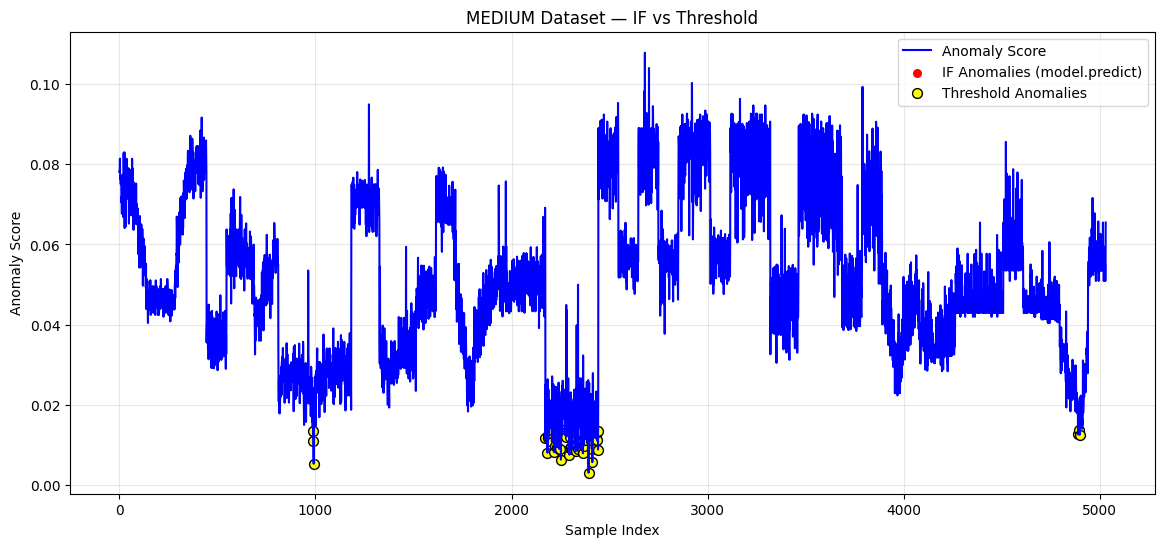

Numar anomalii IF: 0
Numar anomalii Threshold: 51


In [14]:
# anomaly score
scores_med = model.decision_function(X_med)

# anomalii IF (cele detectate de modle)
labels_if_med = (model.predict(X_med) == -1).astype(int)

# anomalii THRESHOLD (cele dupa scor)
threshold = np.percentile(scores_med, 1)   # 1% cele mai rare
labels_thr_med = (scores_med < threshold).astype(int)

print("MEDIUM — Anomalii IF:", np.sum(labels_if_med))
print("MEDIUM — Anomalii Threshold:", np.sum(labels_thr_med))
print("Threshold MEDIUM:", threshold)

plot_dual_anomalies(scores_med, labels_if_med, labels_thr_med, "MEDIUM Dataset — IF vs Threshold")


In [15]:
path_high = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_high_processed.csv"

df_high = load_dataset(path_high)
X_high, scaler_high = preprocess(df_high)

Folosesc features: ['RSSI', 'SNRCurrent_URLLC', 'RSRQCurrent_URLLC', 'RSRPCurrent_URLLC', 'BytesSent_URLLC', 'BytesReceived_URLLC', 'BytesSent_eMBB', 'BytesReceived_eMBB', 'URLLC_BytesSent', 'URLLC_BytesReceived', 'eMBB_BytesSent', 'eMBB_BytesReceived', 'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps', 'eMBB_Sent_thrp_Mbps', 'eMBB_Received_thrp_Mbps']


/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")
/content/drive/MyDrive/AnomalyDetection/src/preprocessing.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


HIGH — Anomalii IF: 0
HIGH — Anomalii Threshold: 41
Threshold HIGH: 0.0076351025555513215


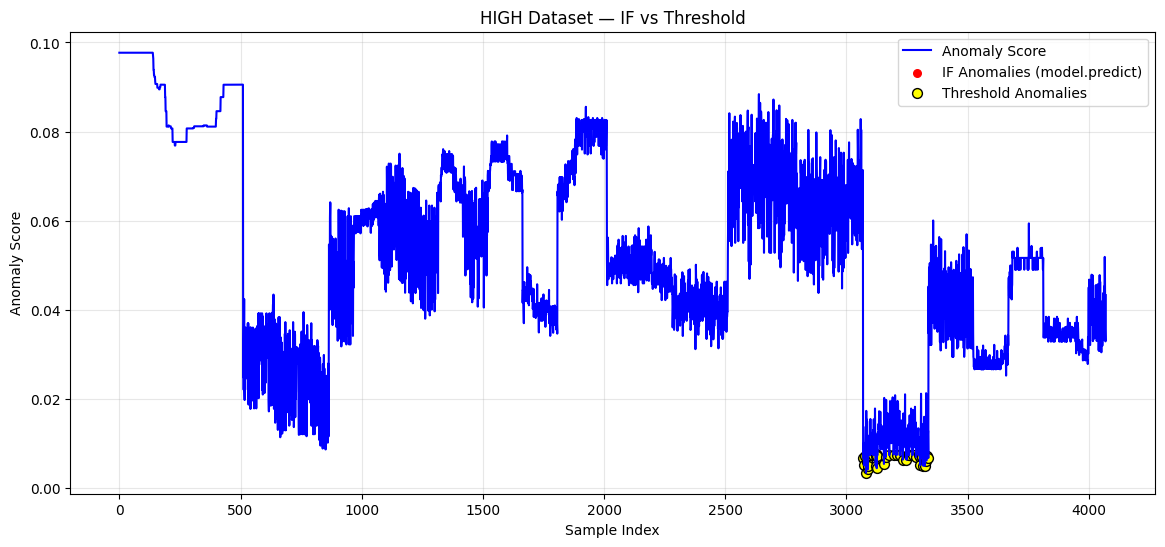

Numar anomalii IF: 0
Numar anomalii Threshold: 41


In [16]:
# anomaly score
scores_high = model.decision_function(X_high)

# anomalii IF (cele detectate de model)
labels_if_high = (model.predict(X_high) == -1).astype(int)

# anomalii THRESHOLD (cele dupa scor)
threshold_high = np.percentile(scores_high, 1)   # 1% cele mai rare
labels_thr_high = (scores_high < threshold_high).astype(int)

print("HIGH — Anomalii IF:", np.sum(labels_if_high))
print("HIGH — Anomalii Threshold:", np.sum(labels_thr_high))
print("Threshold HIGH:", threshold_high)

plot_dual_anomalies(scores_high, labels_if_high, labels_thr_high, "HIGH Dataset — IF vs Threshold")

In [17]:
import pandas as pd

path = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal_processed.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
print("\n        ANALIZA COLOANELOR\n")

constant_cols = []
empty_cols = []
almost_constant_cols = []
useful_cols = []

for col in df.columns:
    nunique = df[col].nunique(dropna=True)
    total = len(df[col])
    most_freq = df[col].value_counts(dropna=True).max() if nunique > 0 else 0

    # 1. complet goala
    if df[col].count() == 0:
        empty_cols.append(col)
        continue

    # 2. complet constanta
    if nunique == 1:
        constant_cols.append(col)
        continue

    # 3. >99% aceeasi valoare
    if most_freq / total > 0.99:
        almost_constant_cols.append(col)
        continue

    # 4. altfel → utila
    useful_cols.append(col)


print("  Coloane COMPLET GOALE:")
print(empty_cols, "\n")

print("  Coloane CONSTANTE (o singura valoare):")
print(constant_cols, "\n")

print("  Coloane aproape CONSTANTE (>99% aceeasi valoare):")
print(almost_constant_cols, "\n")

print("  Coloane UTILIZABILE pentru Machine Learning:")
print(useful_cols, "\n")

print("Numar total coloane:", len(df.columns))
print("Coloane utile pentru model:", len(useful_cols))


Shape: (4193, 20)

        ANALIZA COLOANELOR

  Coloane COMPLET GOALE:
['APN_eMBB', 'APN_URLLC', 'BytesSent_eMBB', 'BytesReceived_eMBB'] 

  Coloane CONSTANTE (o singura valoare):
['imsi', 'RSRQCurrent_URLLC', 'eMBB_BytesSent', 'eMBB_BytesReceived', 'eMBB_Sent_thrp_Mbps', 'eMBB_Received_thrp_Mbps'] 

  Coloane aproape CONSTANTE (>99% aceeasi valoare):
[] 

  Coloane UTILIZABILE pentru Machine Learning:
['timestamp', 'RSSI', 'SNRCurrent_URLLC', 'RSRPCurrent_URLLC', 'BytesSent_URLLC', 'BytesReceived_URLLC', 'URLLC_BytesSent', 'URLLC_BytesReceived', 'URLLC_Sent_thrp_Mbps', 'URLLC_Received_thrp_Mbps'] 

Numar total coloane: 20
Coloane utile pentru model: 10


Anomalii detectate in NORMAL: 5


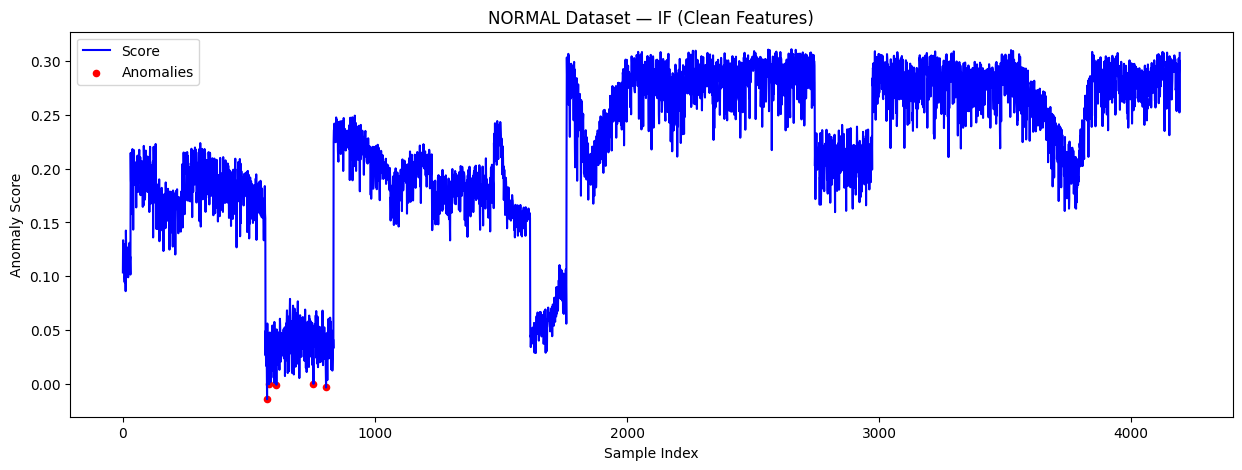

Number of anomalies detected: 5


array([572, 580, 609, 756, 806])

In [18]:
from sklearn.ensemble import IsolationForest
import numpy as np

path_normal = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal_processed.csv"
df_normal = load_dataset(path_normal)
X_normal, scaler_normal = preprocess2(df_normal)

model = IsolationForest(
    contamination=0.001,
    random_state=42,
    n_estimators=300,
    max_samples='auto'
)

model.fit(X_normal)

scores_normal = model.decision_function(X_normal)
labels_normal = model.predict(X_normal)

print("Anomalii detectate in NORMAL:", np.sum(labels_normal == -1))
plot_anomalies(scores_normal, labels_normal, "NORMAL Dataset — IF (Clean Features)")


In [19]:
threshold = np.percentile(scores_normal, 1)
print("Threshold NORMAL =", threshold)


Threshold NORMAL = 0.020121982449596582


MEDIUM - Anomalii IF: 2143
MEDIUM - Anomalii Threshold: 3030


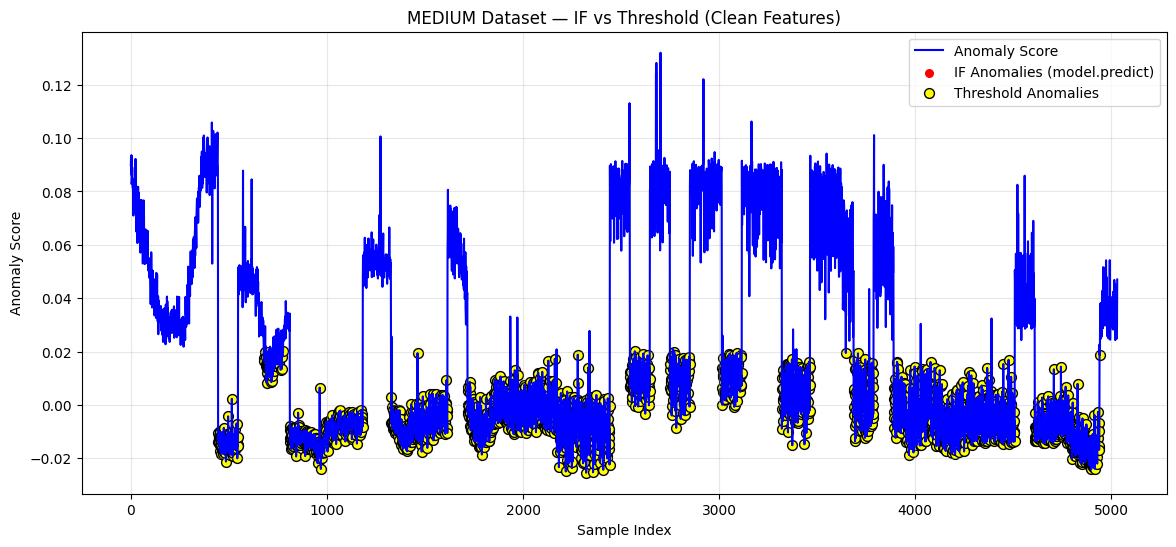

Numar anomalii IF: 0
Numar anomalii Threshold: 3030


In [20]:
path_medium = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_medium_processed.csv"
df_medium = load_dataset(path_medium)
X_medium, _ = preprocess2(df_medium)

scores_medium = model.decision_function(X_medium)

labels_if_medium = (model.predict(X_medium) == -1).astype(int)
labels_thr_medium = (scores_medium < threshold).astype(int)

print("MEDIUM - Anomalii IF:", np.sum(labels_if_medium))
print("MEDIUM - Anomalii Threshold:", np.sum(labels_thr_medium))

plot_dual_anomalies(
    scores_medium,
    labels_if_medium,
    labels_thr_medium,
    "MEDIUM Dataset — IF vs Threshold (Clean Features)"
)


HIGH - Anomalii IF: 1052
HIGH - Anomalii Threshold: 2236


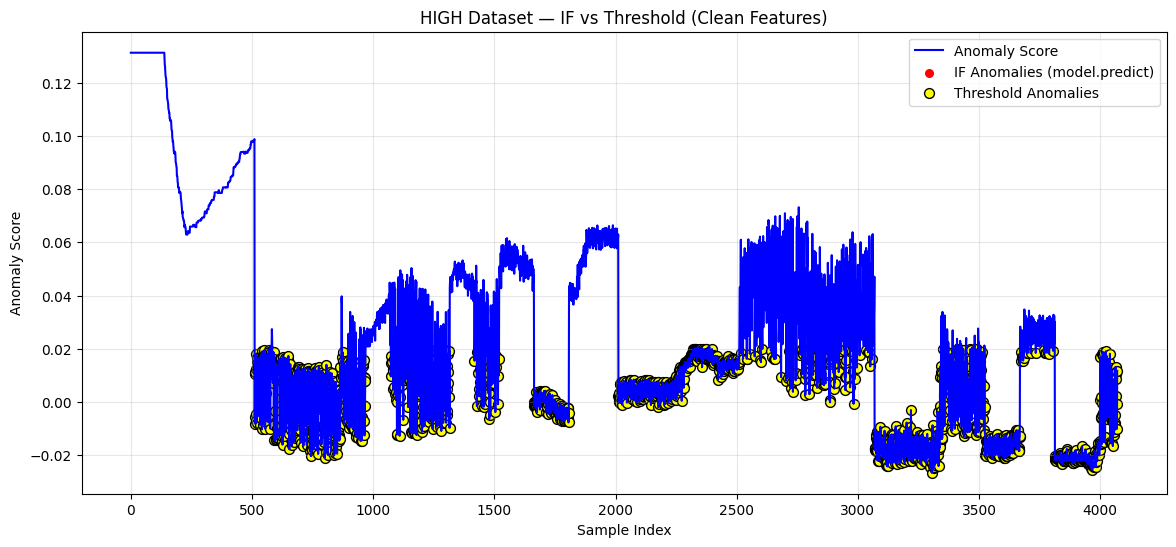

Numar anomalii IF: 0
Numar anomalii Threshold: 2236


In [21]:
path_high = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_high_processed.csv"
df_high = load_dataset(path_high)
X_high, _ = preprocess2(df_high)

scores_high = model.decision_function(X_high)

labels_if_high = (model.predict(X_high) == -1).astype(int)
labels_thr_high = (scores_high < threshold).astype(int)

print("HIGH - Anomalii IF:", np.sum(labels_if_high))
print("HIGH - Anomalii Threshold:", np.sum(labels_thr_high))

plot_dual_anomalies(
    scores_high,
    labels_if_high,
    labels_thr_high,
    "HIGH Dataset — IF vs Threshold (Clean Features)"
)


In [22]:
# PATH catre datasetul ramp-up
path_ramp = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal-medium_ramp-up_processed-1.csv"

df_ramp = load_dataset(path_ramp)

# preprocesare cu cele 9 coloane importante
X_ramp, _ = preprocess2(df_ramp)


RAMP-UP — Anomalii IF: 1507
RAMP-UP — Anomalii Threshold: 1597
Threshold RAMP-UP: 0.020121982449596582


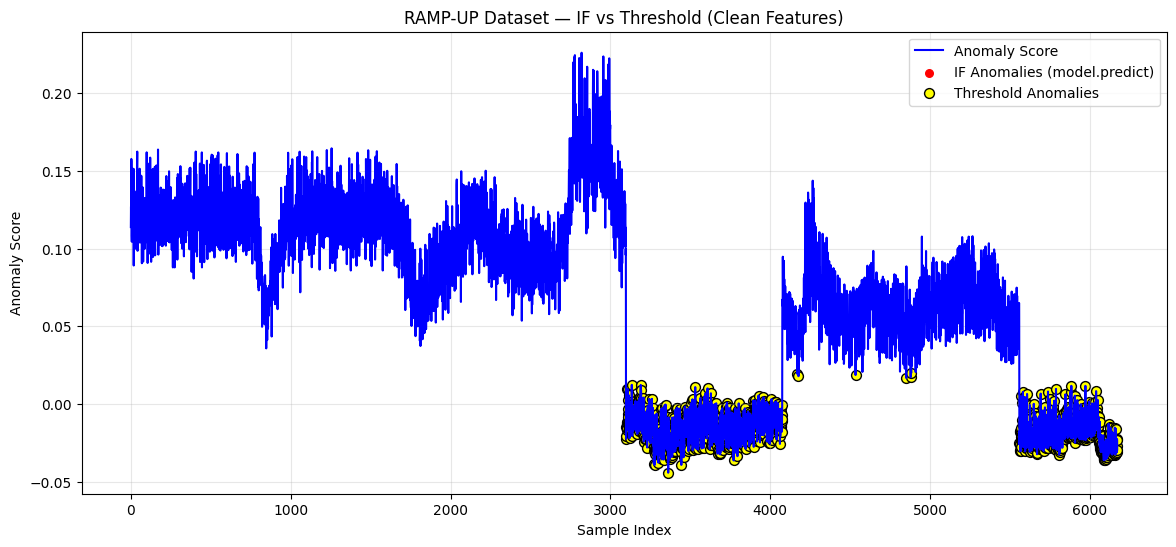

Numar anomalii IF: 0
Numar anomalii Threshold: 1597


In [23]:
# scoruri anomaly pentru ramp-up
scores_ramp = model.decision_function(X_ramp)

# anomalii IF (model.predict)
labels_if_ramp = (model.predict(X_ramp) == -1).astype(int)

labels_thr_ramp = (scores_ramp < threshold).astype(int)

print("RAMP-UP — Anomalii IF:", np.sum(labels_if_ramp))
print("RAMP-UP — Anomalii Threshold:", np.sum(labels_thr_ramp))
print("Threshold RAMP-UP:", threshold)

plot_dual_anomalies(
    scores_ramp,
    labels_if_ramp,
    labels_thr_ramp,
    "RAMP-UP Dataset — IF vs Threshold (Clean Features)"
)


In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_only_if_anomalies(scores, labels_if, title="IF Anomalies Only"):
    anomalies = np.where(labels_if == 1)[0]   # 1 = anomalii IF

    plt.figure(figsize=(15,5))
    plt.plot(scores, label="Anomaly Score", color="blue")

    # doar anomaliile IF în rosu
    plt.scatter(anomalies, scores[anomalies], color="red", s=20, label="IF Anomalies")

    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Anomaly Score")
    plt.legend()
    plt.show()

    print("Numar anomalii IF:", len(anomalies))


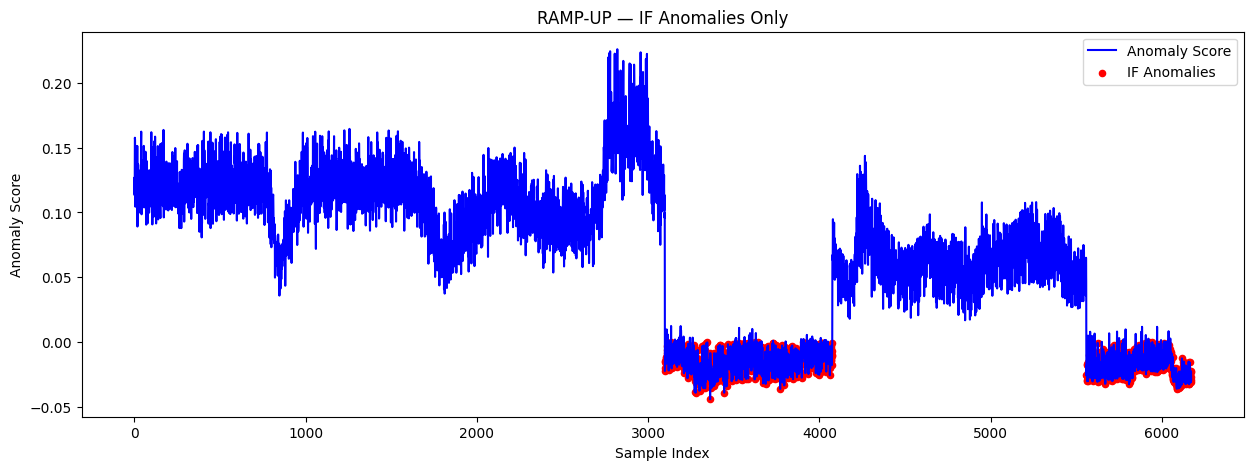

Numar anomalii IF: 1507


In [25]:
plot_only_if_anomalies(scores_ramp, labels_if_ramp, "RAMP-UP — IF Anomalies Only")


In [26]:
paths = [
    "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal_processed.csv",
    "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_medium_processed.csv",
    "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_high_processed.csv"
]

dfs = [load_dataset(p) for p in paths]
df_all = pd.concat(dfs, ignore_index=True)


In [27]:
X_all, scaler_all = preprocess2(df_all)

print("Shape total training:", X_all.shape)


Shape total training: (13295, 9)


In [28]:
from sklearn.ensemble import IsolationForest

model_combined = IsolationForest(
    contamination=0.001,
    random_state=42,
    n_estimators=400,
    max_samples='auto'
)

model_combined.fit(X_all)


IsolationForest(contamination=0.001, n_estimators=400, random_state=42)

NORMAL - Anomalii IF (model nou): 263


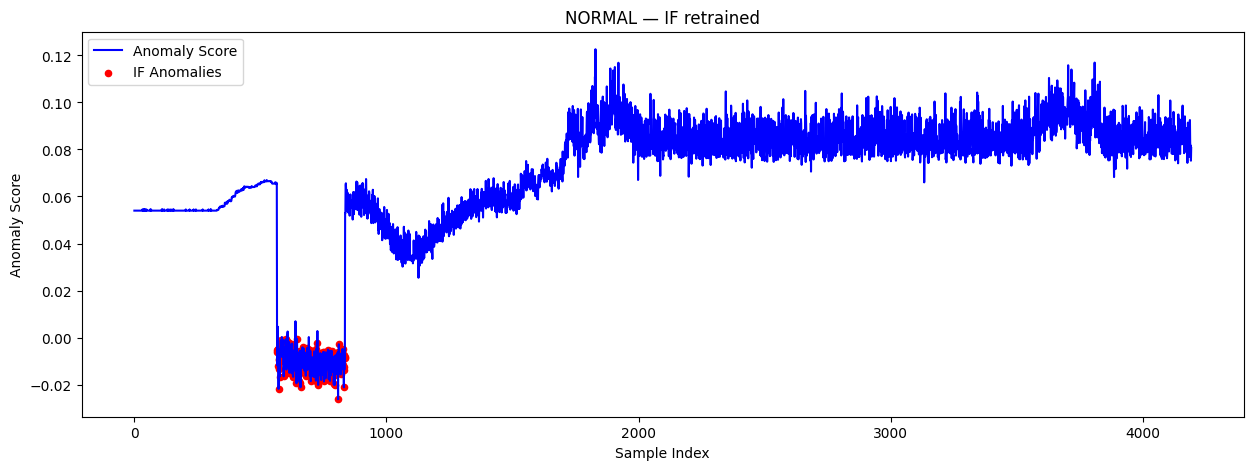

Numar anomalii IF: 263


In [29]:
scores_normal2 = model_combined.decision_function(X_normal)
labels_normal2 = (model_combined.predict(X_normal) == -1)

print("NORMAL - Anomalii IF (model nou):", labels_normal2.sum())
plot_only_if_anomalies(scores_normal2, labels_normal2, "NORMAL — IF retrained")


MEDIUM - Anomalii IF (model nou): 145


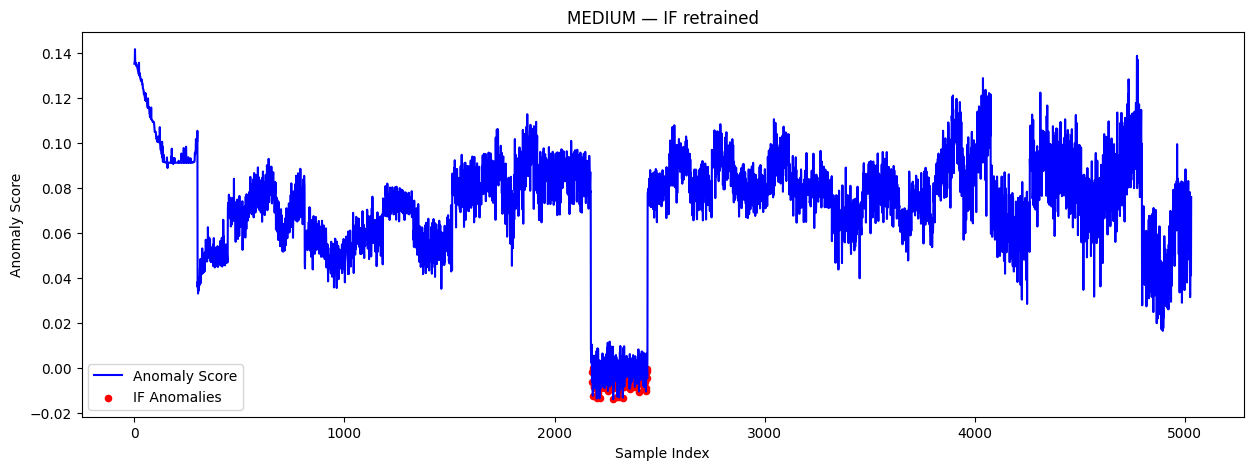

Numar anomalii IF: 145


In [30]:
scores_medium2 = model_combined.decision_function(X_medium)
labels_medium2 = (model_combined.predict(X_medium) == -1)

print("MEDIUM - Anomalii IF (model nou):", labels_medium2.sum())
plot_only_if_anomalies(scores_medium2, labels_medium2, "MEDIUM — IF retrained")


HIGH - Anomalii IF (model nou): 2


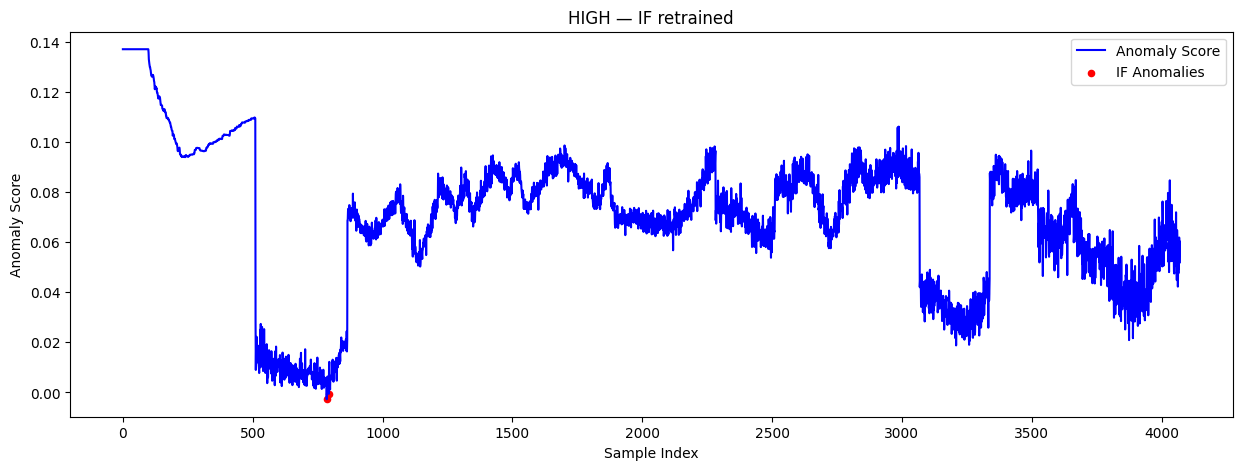

Numar anomalii IF: 2


In [31]:
scores_high2 = model_combined.decision_function(X_high)
labels_high2 = (model_combined.predict(X_high) == -1)

print("HIGH - Anomalii IF (model nou):", labels_high2.sum())
plot_only_if_anomalies(scores_high2, labels_high2, "HIGH — IF retrained")


In [32]:
path_ramp = "/content/drive/MyDrive/AnomalyDetection/data/2_CPE_Buc_Indoor_normal-medium_ramp-up_processed-1.csv"

df_ramp = load_dataset(path_ramp)
X_ramp, _ = preprocess2(df_ramp)

print("RAMP-UP shape:", X_ramp.shape)


RAMP-UP shape: (6172, 9)


In [33]:
scores_ramp2 = model_combined.decision_function(X_ramp)


In [34]:
labels_ramp2 = (model_combined.predict(X_ramp) == -1)
print("RAMP-UP — Anomalii IF (model retrained):", labels_ramp2.sum())


RAMP-UP — Anomalii IF (model retrained): 33


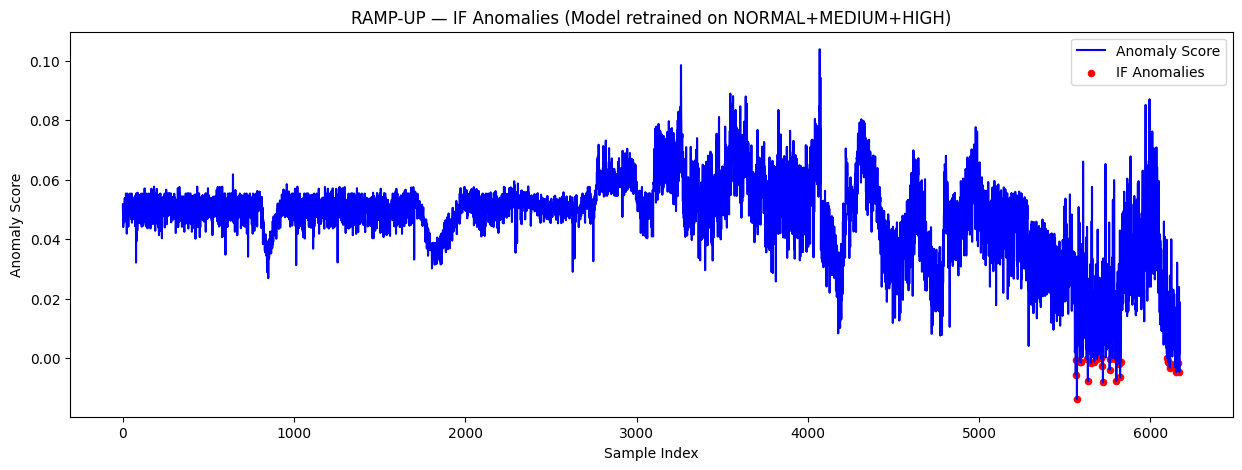

Numar anomalii IF: 33


In [35]:
plot_only_if_anomalies(
    scores_ramp2,
    labels_ramp2,
    "RAMP-UP — IF Anomalies (Model retrained on NORMAL+MEDIUM+HIGH)"
)


In [36]:
import numpy as np

def anomaly_statistics(df, scores, labels_if, name="DATASET"):
    labels_if = np.array(labels_if)
    anomaly_idx = np.where(labels_if == 1)[0]

    stats = {}
    stats["dataset"] = name
    stats["total_samples"] = len(scores)
    stats["total_anomalies"] = len(anomaly_idx)
    stats["anomaly_ratio_%"] = 100 * len(anomaly_idx) / len(scores)

    # scoruri
    stats["score_mean"] = float(np.mean(scores))
    stats["score_std"] = float(np.std(scores))
    stats["score_min"] = float(np.min(scores))
    stats["score_max"] = float(np.max(scores))
    stats["score_p01"] = float(np.percentile(scores, 1))
    stats["score_p99"] = float(np.percentile(scores, 99))

    # daca avem timestamp
    if "timestamp" in df.columns:
        stats["duration"] = f"{df['timestamp'].iloc[0]}  →  {df['timestamp'].iloc[-1]}"

    # burst detection (grupuri de anomalii consecutive)
    bursts = []
    if len(anomaly_idx) > 0:
        current_burst = [anomaly_idx[0]]
        for idx in anomaly_idx[1:]:
            if idx == current_burst[-1] + 1:
                current_burst.append(idx)
            else:
                bursts.append(len(current_burst))
                current_burst = [idx]
        bursts.append(len(current_burst))

    stats["num_bursts"] = len(bursts)
    stats["avg_burst_len"] = float(np.mean(bursts)) if bursts else 0
    stats["max_burst_len"] = max(bursts) if bursts else 0

    return stats


In [37]:
# NORMAL
labels_normal2 = (model_combined.predict(X_normal) == -1).astype(int)
stats_normal2 = anomaly_statistics(df_normal, scores_normal2, labels_normal2, "NORMAL_COMBINED")

# MEDIUM
labels_medium2 = (model_combined.predict(X_medium) == -1).astype(int)
stats_medium2 = anomaly_statistics(df_medium, scores_medium2, labels_medium2, "MEDIUM_COMBINED")

# HIGH
labels_high2 = (model_combined.predict(X_high) == -1).astype(int)
stats_high2 = anomaly_statistics(df_high, scores_high2, labels_high2, "HIGH_COMBINED")

# RAMP-UP
labels_ramp2 = (model_combined.predict(X_ramp) == -1).astype(int)
stats_ramp2 = anomaly_statistics(df_ramp, scores_ramp2, labels_ramp2, "RAMPUP_COMBINED")

# tabel final
pd.DataFrame([stats_normal2, stats_medium2, stats_high2, stats_ramp2])


,dataset,total_samples,total_anomalies,anomaly_ratio_%,score_mean,score_std,score_min,score_max,score_p01,score_p99,duration,num_bursts,avg_burst_len,max_burst_len
0,NORMAL_COMBINED,4193,263,6.272359,0.069438,0.026545,-0.026226,0.122633,-0.015003,0.103833,2024-05-07 10:08:30 → 2024-05-07 15:57:50,7,37.571429,109
1,MEDIUM_COMBINED,5031,145,2.882131,0.072668,0.024816,-0.013946,0.141541,-0.006061,0.122243,2024-05-09 09:00:45 → 2024-05-09 15:59:55,72,2.013889,6
2,HIGH_COMBINED,4071,2,0.049128,0.069779,0.027974,-0.002727,0.137106,0.004312,0.137106,2024-05-08 13:00:10 → 2024-05-08 18:39:20,2,1.000000,1
3,RAMPUP_COMBINED,6172,33,0.534673,0.047523,0.014051,-0.013823,0.103916,0.003424,0.077275,2024-05-14 06:01:40 → 2024-05-14 14:35:55,30,1.100000,2


In [38]:
from sklearn.cluster import DBSCAN
import numpy as np

def run_dbscan(X, eps=0.3, min_samples=20):
    """
    Returneaza:
      - labels: cluster ID pentru fiecare punct (−1 = anomalie)
      - core_samples: indexurile punctelor centrale (nu e neaparat necesar)
    """
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)
    return labels, model


In [39]:
import matplotlib.pyplot as plt

def plot_dbscan_anomalies(scores, labels, title="DBSCAN Anomalies"):
    anomalies = np.where(labels == -1)[0]

    plt.figure(figsize=(15,5))
    plt.plot(scores, label="Score", color="blue")
    plt.scatter(anomalies, scores[anomalies], color="red", label="DBSCAN Outliers", s=20)
    plt.title(title)
    plt.legend()
    plt.show()

    print(f"Total anomalii DBSCAN: {len(anomalies)}")


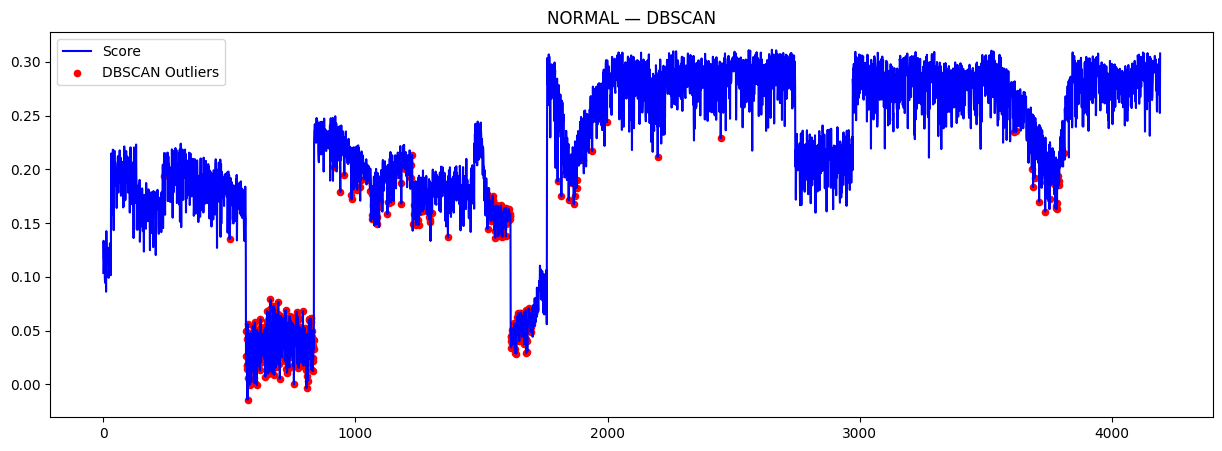

Total anomalii DBSCAN: 540


In [40]:
labels_db_normal, dbscan_normal = run_dbscan(X_normal, eps=0.3, min_samples=20)
plot_dbscan_anomalies(scores_normal, labels_db_normal, "NORMAL — DBSCAN")


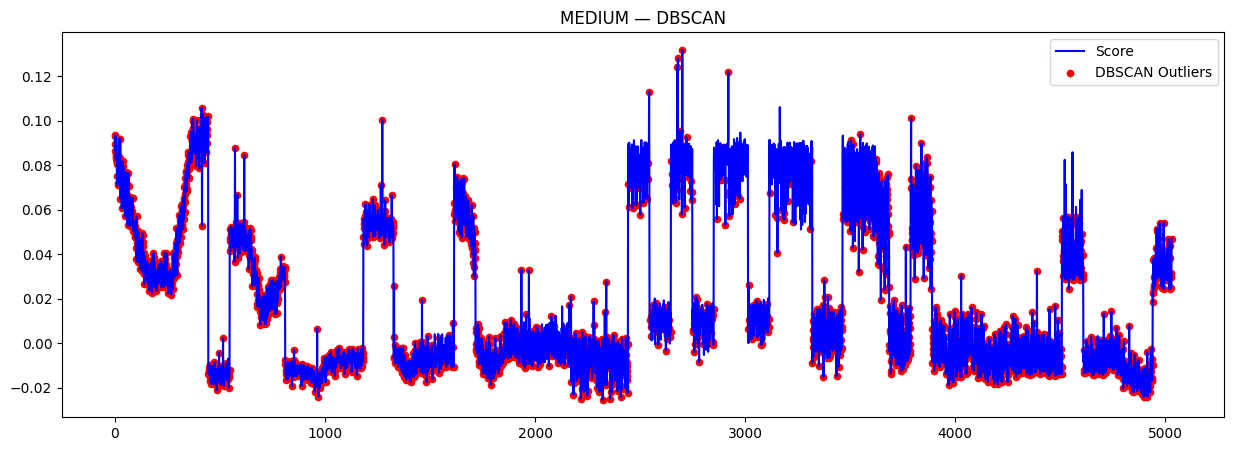

Total anomalii DBSCAN: 3874


In [41]:
labels_db_medium, dbscan_medium = run_dbscan(X_medium, eps=0.3, min_samples=20)
plot_dbscan_anomalies(scores_medium, labels_db_medium, "MEDIUM — DBSCAN")


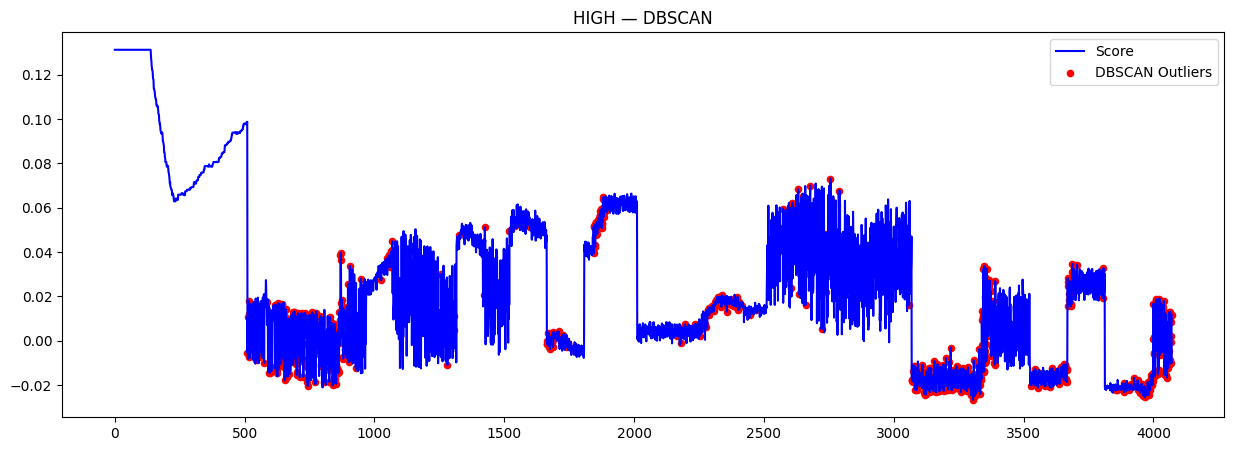

Total anomalii DBSCAN: 949


In [42]:
labels_db_high, dbscan_high = run_dbscan(X_high, eps=0.3, min_samples=20)
plot_dbscan_anomalies(scores_high, labels_db_high, "HIGH — DBSCAN")


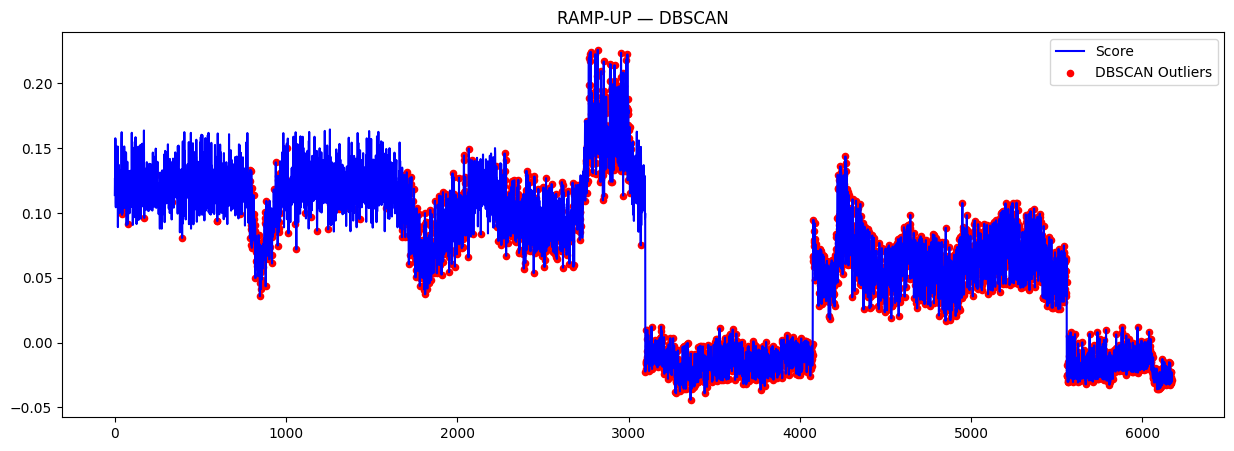

Total anomalii DBSCAN: 4039


In [43]:
labels_db_ramp, dbscan_ramp = run_dbscan(X_ramp, eps=0.3, min_samples=20)
plot_dbscan_anomalies(scores_ramp, labels_db_ramp, "RAMP-UP — DBSCAN")


In [44]:
from sklearn.cluster import DBSCAN
import numpy as np

def find_best_dbscan(X, eps_values, min_samples_values):
    best_cfg = None
    best_score = None  # scor = distanta fata de 10% anomalii

    results = []

    for eps in eps_values:
        for ms in min_samples_values:
            labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
            anomalies = np.sum(labels == -1)
            ratio = anomalies / len(X)

            # vrem un ratio intre 1% si 15%
            if 0.01 <= ratio <= 0.15:
                score = abs(ratio - 0.05)  # vrem in jur de 5%

                if best_score is None or score < best_score:
                    best_score = score
                    best_cfg = (eps, ms)

            results.append((eps, ms, ratio))

    return best_cfg, results


In [45]:
eps_grid = np.linspace(0.1, 1.0, 10)
min_samples_grid = [5, 10, 15, 20, 30]

best_cfg, results = find_best_dbscan(X_normal, eps_grid, min_samples_grid)

best_cfg, sorted(results, key=lambda x: abs(x[2] - 0.05))[:10]


((np.float64(0.4), 10),
 [(np.float64(0.4), 10, np.float64(0.051991414261865015)),
  (np.float64(0.5), 30, np.float64(0.0379203434295254)),
  (np.float64(0.4), 5, np.float64(0.02790364893870737)),
  (np.float64(0.4), 15, np.float64(0.07345575959933222)),
  (np.float64(0.30000000000000004), 5, np.float64(0.07440973050321965)),
  (np.float64(0.5), 20, np.float64(0.01764846172191748)),
  (np.float64(0.4), 20, np.float64(0.08466491772000954)),
  (np.float64(0.5), 15, np.float64(0.013594085380395898)),
  (np.float64(0.5), 10, np.float64(0.00882423086095874)),
  (np.float64(0.5), 5, np.float64(0.005246839971380873))])

In [46]:
db_best = DBSCAN(eps=best_cfg[0], min_samples=best_cfg[1])
labels_best = db_best.fit_predict(X_normal)


In [47]:
print("NORMAL anomalies:", np.sum(labels_best == -1))


NORMAL anomalies: 218


In [48]:
np.isnan(X_normal).sum() == 0
np.isnan(X_high).sum() == 0

np.True_